### Goal of this notebook is to compare the performance of GaussianNB, MultinomialNB and BernoulliNB for continuous valued attributes

### Loading the Pima Indians Diabetes Dataset

1. Title: Pima Indians Diabetes Dataset: [Pima Indians Diabetes](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) from the UCI Machine Learning Repository
2. Number of Instances: 768

3. Number of Attributes: 8 plus class 

4. For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

5. Missing Attribute Values: Yes

6. Class Distribution: (class value 1 is interpreted as "tested positive for diabetes")

   Class Value  Number of instances
   0            500
   1            268

In [7]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline

from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 12
#plt.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive 

In [8]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin_fold', 'serum_insulin', 'bmi', 'pedigree', 'age', 'label']
pima_df = pd.read_csv(url, header=None, names=col_names)
pima_df.head(10)

,pregnant,glucose,bp,skin_fold,serum_insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [9]:
pipelines = [
                Pipeline([
                    ('GaussianNB', GaussianNB())                   # testing accuracy of Gaussian Naive Bayes
                ]),
                Pipeline([
                    ('MultinomialNB', MultinomialNB(alpha=0.01))   # testing accuracy of Multinomial Naive Bayes
                ]),
                Pipeline([
                   ('BernoulliNB', BernoulliNB(alpha=0.01))       # testing accuracy of Bernoulli Naive Bayes
                ])        
            ]

In [10]:
from sklearn.cross_validation import train_test_split

X = pima_df.drop('label', axis = 1)
y = pima_df['label']
# stratified split of training and test data based on the distribution of being diabetic or not
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=pima_df['label'])

In [11]:
results = []
for pipeline in pipelines:

    # Fit the classifier        
    pipeline.fit(X_train, y_train)
    
    # Predict the class and probability on the test data
    y_pred = pipeline.predict(X_test)
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    
    #print('Metrics for %s:' % (pipeline.steps[-1][0]))
    # compute precision and recall, or their combination (harmonic mean) F1:
    #print(metrics.classification_report(y_test, y_pred_class))
    
    # first argument is true values, second argument is predicted probabilities
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    # pipeline.steps[-1][0] gives the name of the classifier from the named steps of the pipeline
    #print('AUC for %s is %0.6f:' % (pipeline.steps[-1][0], roc_auc))
    #plt.plot(fpr, tpr, lw=1, label='%s (AUC = %0.2f)' % (pipeline.steps[-1][0], roc_auc))
    #return clf_descr, score, train_time, test_time
    results.append((pipeline.steps[-1][0], y_test, y_pred, y_pred_prob, fpr, tpr, roc_auc ))

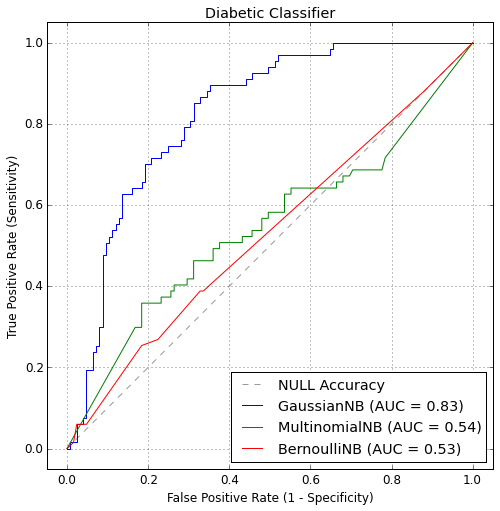

In [12]:
# plot the ROC Curves
plt.figure(figsize=(8,8))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')

for clf, y_test, y_pred, y_pred_prob, fpr, tpr, roc_auc in results:
    plt.plot(fpr, tpr, lw=1, label='%s (AUC = %0.2f)' % (clf, roc_auc))

plt.title('Diabetic Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [13]:
for clf, y_test, y_pred, y_pred_prob, fpr, tpr, roc_auc in results:
    print('Metrics for %s:' % clf)
    # compute precision and recall, or their combination (harmonic mean) F1:
    print(metrics.classification_report(y_test, y_pred))

Metrics for GaussianNB:
             precision    recall  f1-score   support

          0       0.81      0.84      0.82       125
          1       0.68      0.63      0.65        67

avg / total       0.76      0.77      0.76       192

Metrics for MultinomialNB:
             precision    recall  f1-score   support

          0       0.68      0.54      0.60       125
          1       0.38      0.52      0.44        67

avg / total       0.58      0.54      0.55       192

Metrics for BernoulliNB:
             precision    recall  f1-score   support

          0       0.66      0.98      0.79       125
          1       0.57      0.06      0.11        67

avg / total       0.63      0.66      0.55       192



**Conclusion:** When applying Naive Bayes classification to a dataset with **continuous features**, it is better to use Gaussian Naive Bayes than Multinomial Naive Bayes. The latter is suitable for datasets containing **discrete features** (e.g., word counts).
 
Gaussian Naive Bayes [Gaussian Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Gaussian_naive_Bayes), [example](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Sex_classification)